# Q slice
In this notebook we analyse the viriation of the Q value in a specific state changing one dimension. In order to see if the policy changes action accordingly.

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

In [2]:
from fqi.result_plot import *
from fqi.utils import *

In [3]:
%matplotlib inline

Load simulation and track boundaries

In [4]:
sim_file_name = 'ds_with_last_budapest_10.csv'
track_in_file_name = 'budapest_InnerTrackEdge.csv'
track_out_file_name = 'budapest_OuterTrackEdge.csv'

In [5]:
simulation = pd.read_csv(os.path.join(data_path, sim_file_name), dtype={'isReference': bool})
track_in = pd.read_csv(os.path.join(data_path, track_in_file_name))
track_out = pd.read_csv(os.path.join(data_path, track_out_file_name))

Load the algorithm trained with all the state features

In [6]:
algorithm_name_as = 'alg_double_fqi_last_nofilt.pkl'
with open(os.path.join(fqi_exp_path, algorithm_name_as), 'rb') as a:
    alg_as = pickle.load(a)

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
action_dispatcher_path_as = fqi_exp_path + '/AD_alg_double_fqi_last_nofilt.pkl'
with open(action_dispatcher_path_as, 'rb') as ad:
    action_dispatcher_as = pickle.load(ad)

Load the algorithm trained with the reduced set of state features

In [8]:
algorithm_name_rs = 'alg_double_fqi_last_new_state_v4.pkl'#'alg_double_fqi_last_reduced_state_nofilt.pkl'
with open(os.path.join(fqi_exp_path, algorithm_name_rs), 'rb') as a:
    alg_rs = pickle.load(a)

In [9]:
action_dispatcher_path_rs = fqi_exp_path + '/AD_alg_double_fqi_last_new_state_v4.pkl' #alg_double_fqi_last_reduced_state_nofilt.pkl'
with open(action_dispatcher_path_rs, 'rb') as ad:
    action_dispatcher_rs = pickle.load(ad)

In [10]:
reduced_state_cols = ['xCarWorld', 'yCarWorld', 'positionRho', 'positionTheta',
              'actualCurvature', 'referenceCurvature',
              'actualSpeedModule', 'speedDifferenceOfModules',
              'actualAccelerationX', 'actualAccelerationY', 'accelerationDiffX', 'accelerationDiffY',
              'nYawBody', 'nEngine', 'NGear'] + prev_action_cols

# N Engine slice
For the engine slice we focus on the end of a curve when the pilot starts to acccelerate but the n-engines and the speed are low.

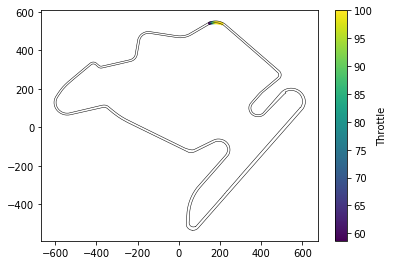

In [11]:
f, ax = plot_track(track_in, track_out)
interval = range(520, 530)
lap_mask = simulation.NLap == 1
v = simulation.rThrottlePedal[lap_mask].values[interval]
s = ax.scatter(simulation.xCarWorld[lap_mask].values[interval],
               simulation.yCarWorld[lap_mask].values[interval],
           c=v, s=5)
c = f.colorbar(s, ax=ax)
c.set_label('Throttle')

Set the point to examine (red line)

In [12]:
position = 526

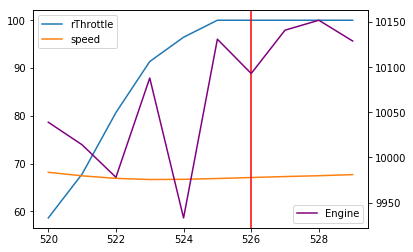

In [13]:
f, ax = plt.subplots()
ax.plot(interval, simulation['rThrottlePedal'][lap_mask].values[interval])
ax.plot(interval, simulation['actualSpeedModule'][lap_mask].values[interval])
ax.axvline(x=position, color='r')
ax.legend(['rThrottle', 'speed'], loc='upper left')
ax2 = ax.twinx()
ax2.plot(interval, simulation['nEngine'][lap_mask].values[interval], 'purple')
ax2.legend(['Engine'], loc='lower right')

All the state features of this point

In [14]:
simulation[state_cols+action_cols][lap_mask].iloc[position]

xCarWorld                               189.982300
yCarWorld                               542.139800
positionReferenceX                      188.913544
positionReferenceY                      542.388733
nYawBody                                  0.650541
nEngine                               10093.000000
NGear                                     7.000000
positionRho                               1.097385
positionTheta                            -0.082911
positionLeft                              0.000000
positionRight                             1.000000
positionRelativeX                         1.093613
positionRelativeY                        -0.090881
actualCurvature                           0.055948
referenceCurvature                        0.065686
actualSpeedModule                        67.107460
referenceSpeedAngle                      -0.000000
speedDifferenceVectorModule               0.961662
speedDifferenceOfModules                  0.961662
actualAccelerationModule       

In [15]:
simulation[reduced_state_cols+action_cols][lap_mask].iloc[position]

xCarWorld                     189.982300
yCarWorld                     542.139800
positionRho                     1.097385
positionTheta                  -0.082911
actualCurvature                 0.055948
referenceCurvature              0.065686
actualSpeedModule              67.107460
speedDifferenceOfModules        0.961662
actualAccelerationX             2.240028
actualAccelerationY           -39.632050
accelerationDiffX              -5.306211
accelerationDiffY              -4.972229
nYawBody                        0.650541
nEngine                     10093.000000
NGear                           7.000000
prevpBrakeF                     0.013872
prevaSteerWheel                -0.924386
prevrThrottlePedal            100.000000
pBrakeF                         0.012517
aSteerWheel                    -0.948780
rThrottlePedal                100.000000
Name: 526, dtype: float64

## All state features
We compute the action set for the state and the set of state variation - actions

In [16]:
s = simulation[state_cols].values[position, :]
ids = (action_dispatcher_as.kdtree.
       query_radius(s.reshape(1,-1)[:, action_dispatcher_as.state_mask], r=action_dispatcher_as.radius))
a = [action_dispatcher_as.actions[i] for i in ids[0]]
print('N actions {}'.format(len(a)))

N actions 154


Plot the action distribution

Text(0,0.5,'steer')

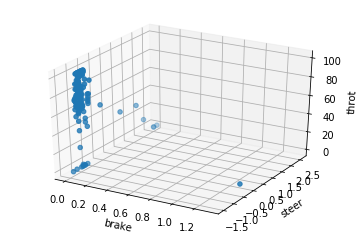

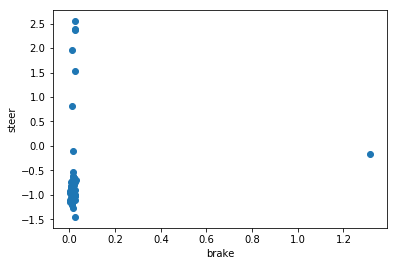

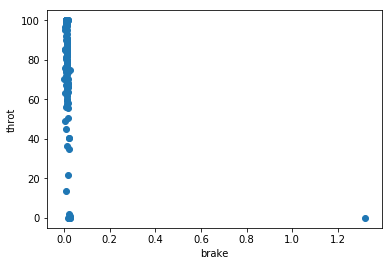

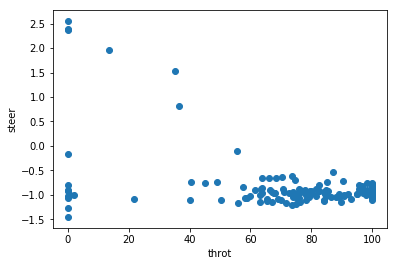

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
brake = [x[0] for x in a]
steer = [x[1] for x in a]
throt = [x[2] for x in a]
ax.scatter(brake, steer, throt)
ax.set_xlabel('brake')
ax.set_ylabel('steer')
ax.set_zlabel('throt')

f = plt.figure()
plt.scatter(brake, steer)
plt.xlabel('brake')
plt.ylabel('steer')
f = plt.figure()
plt.scatter(brake, throt)
plt.xlabel('brake')
plt.ylabel('throt')
f = plt.figure()
plt.scatter(throt, steer)
plt.xlabel('throt')
plt.ylabel('steer')

In [18]:
engine_pos = [i for i,st in enumerate(state_cols) if st == 'nEngine']

print('N engine {}'.format(s[engine_pos]))

engine_variations = np.array(range(8000, 18200, 200))

print('Number of engine variations {}'.format(len(engine_variations)))

N engine [10093.]
Number of engine variations 51


Create state slices matrix

In [19]:
state_slices = np.matlib.repmat(s, len(engine_variations), 1)

state_slices[:, engine_pos] = engine_variations.reshape(-1, 1)

n_actions = len(a)
n_slices = len(state_slices)
state_dim = len(state_cols)
action_dim = len(action_cols)

sa = np.empty((n_slices*n_actions, state_dim+action_dim))
end = 0
for i in range(n_slices):
    # set state interval variables
    start = end
    end = end + n_actions

    # populate the matrix with the ith state prime
    sa[start:end, 0:state_dim] = np.matlib.repmat(state_slices[i, :], n_actions, 1)

    # populate the matrix with the actions of the action set of ith state prime
    sa[start:end, state_dim:] = np.array(a).reshape((n_actions, action_dim))

print('Shape of sa {}'.format(sa.shape))

Shape of sa (7854, 33)


Compute the Q values of the slice matrix

In [20]:
q_value = alg_as._policy.Q.values(sa)

print('Shape of q_value {}'.format(q_value.shape))

AttributeError: An Nx(S+A) matrix must be provided

In [ ]:
q_value = q_value.reshape(n_slices, -1)

print('Shape of q_value {}'.format(q_value.shape))

Take key actions for which analyse the Q value

In [ ]:
thrt_0 = [i for i,x in enumerate(a) if x[2] <= 20]
thrt_20 = [i for i,x in enumerate(a) if (x[2]>=15) & (x[2]<= 25)]
thrt_50 = [i for i,x in enumerate(a) if (x[2]>=45) & (x[2]<= 55)]
thrt_70 = [i for i,x in enumerate(a) if (x[2]>=65) & (x[2]<= 75)]
thrt_80 = [i for i,x in enumerate(a) if (x[2]>=75) & (x[2]<= 85)]
thrt_90 = [i for i,x in enumerate(a) if (x[2]>=85) & (x[2]<= 95)]
thrt_100 = [i for i,x in enumerate(a) if x[2] == 100]

In [ ]:
np.array(a)[[thrt_0[0], thrt_20[0], thrt_50[0], thrt_70[0], thrt_80[0], thrt_90[0], thrt_100[0]], :]

See the standard deviations of the other action dimensions

In [ ]:
np.std(np.array(a)[[thrt_0[0], thrt_20[0], thrt_50[0], thrt_70[0], thrt_80[0], thrt_90[0], thrt_100[0]], :], axis=0)

Plot the Q value slices

In [ ]:
plt.figure(figsize=[10,5])
plt.plot(q_value[:, [thrt_0[0], thrt_20[0], thrt_50[0], thrt_70[0], thrt_80[0], thrt_90[0], thrt_100[0]]])
plt.xticks(range(n_slices), engine_variations, rotation=90)
plt.legend(['0', '20', '50', '70', '80', '90', '100'])
plt.xlabel('N Engine')
plt.ylabel('Q value')
plt.title('Q values for Throttle varying N Engine')

## Reduced state features
We compute the action set for the state and the set of state variation - actions

In [21]:
s = simulation[reduced_state_cols].values[position, :]
ids = (action_dispatcher_rs.kdtree.
       query_radius(s.reshape(1,-1)[:, action_dispatcher_rs.state_mask], r=action_dispatcher_rs.radius))
a = [action_dispatcher_rs.actions[i] for i in ids[0]]
print('N actions {}'.format(len(a)))

N actions 154


Plot the action distribution

Text(0,0.5,'steer')

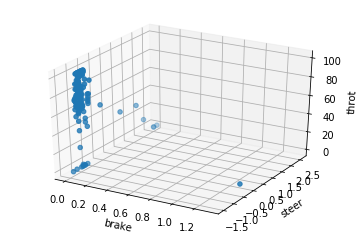

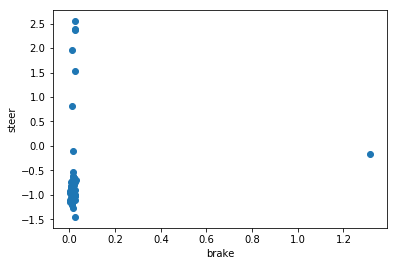

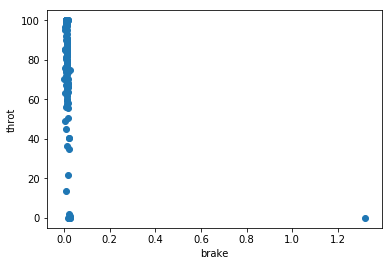

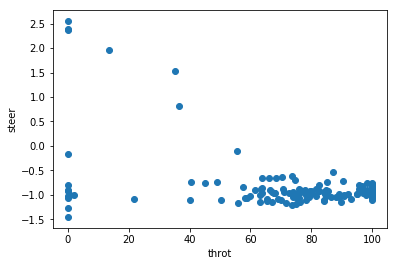

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
brake = [x[0] for x in a]
steer = [x[1] for x in a]
throt = [x[2] for x in a]
ax.scatter(brake, steer, throt)
ax.set_xlabel('brake')
ax.set_ylabel('steer')
ax.set_zlabel('throt')

f = plt.figure()
plt.scatter(brake, steer)
plt.xlabel('brake')
plt.ylabel('steer')
f = plt.figure()
plt.scatter(brake, throt)
plt.xlabel('brake')
plt.ylabel('throt')
f = plt.figure()
plt.scatter(throt, steer)
plt.xlabel('throt')
plt.ylabel('steer')

In [23]:
engine_pos = [i for i,st in enumerate(reduced_state_cols) if st == 'nEngine']

print('N engine {}'.format(s[engine_pos]))

engine_variations = np.array(range(8000, 18200, 200))

print('Number of engine variations {}'.format(len(engine_variations)))

N engine [10093.]
Number of engine variations 51


Create state slices matrix

In [24]:
state_slices = np.matlib.repmat(s, len(engine_variations), 1)

state_slices[:, engine_pos] = engine_variations.reshape(-1, 1)

n_actions = len(a)
n_slices = len(state_slices)
state_dim = len(reduced_state_cols)
action_dim = len(action_cols)

sa = np.empty((n_slices*n_actions, state_dim+action_dim))
end = 0
for i in range(n_slices):
    # set state interval variables
    start = end
    end = end + n_actions

    # populate the matrix with the ith state prime
    sa[start:end, 0:state_dim] = np.matlib.repmat(state_slices[i, :], n_actions, 1)

    # populate the matrix with the actions of the action set of ith state prime
    sa[start:end, state_dim:] = np.array(a).reshape((n_actions, action_dim))

print('Shape of sa {}'.format(sa.shape))

Shape of sa (7854, 21)


Compute the Q values of the slice matrix

In [25]:
sa.shape

(7854, 21)

In [26]:
q_value = alg_rs._policy.Q.values(sa)

print('Shape of q_value {}'.format(q_value.shape))

Shape of q_value (7854,)


In [27]:
q_value = q_value.reshape(n_slices, -1)

print('Shape of q_value {}'.format(q_value.shape))

Shape of q_value (51, 154)


Take key actions for which analyse the Q values

In [28]:
thrt_0 = [i for i,x in enumerate(a) if x[2] <= 20]
thrt_20 = [i for i,x in enumerate(a) if (x[2]>=15) & (x[2]<= 25)]
thrt_50 = [i for i,x in enumerate(a) if (x[2]>=45) & (x[2]<= 55)]
thrt_70 = [i for i,x in enumerate(a) if (x[2]>=65) & (x[2]<= 75)]
thrt_80 = [i for i,x in enumerate(a) if (x[2]>=75) & (x[2]<= 85)]
thrt_90 = [i for i,x in enumerate(a) if (x[2]>=85) & (x[2]<= 95)]
thrt_100 = [i for i,x in enumerate(a) if x[2] == 100]

In [29]:
np.array(a)[[thrt_0[0], thrt_20[0], thrt_50[0], thrt_70[0], thrt_80[0], thrt_90[0], thrt_100[0]], :]

array([[ 2.12793387e-02, -1.07622397e+00,  0.00000000e+00],
       [ 1.89128648e-02, -1.08775353e+00,  2.17417889e+01],
       [ 9.99386795e-03, -7.62689412e-01,  4.51807365e+01],
       [ 1.47087770e-02, -9.45209324e-01,  7.09474792e+01],
       [ 1.34919975e-02, -8.75625491e-01,  7.58157120e+01],
       [ 1.12231867e-02, -7.26119578e-01,  9.03681183e+01],
       [ 1.36873228e-02, -9.59519088e-01,  1.00000000e+02]])

See the standard deviations of the other action dimensions

In [30]:
np.std(np.array(a)[[thrt_0[0], thrt_20[0], thrt_50[0], thrt_70[0], thrt_80[0], thrt_90[0], thrt_100[0]], :], axis=0)

array([3.73657873e-03, 1.30407635e-01, 3.40989782e+01])

Plot the Q value slices

Text(0.5,1,'Q values for Throttle varying N Engine')

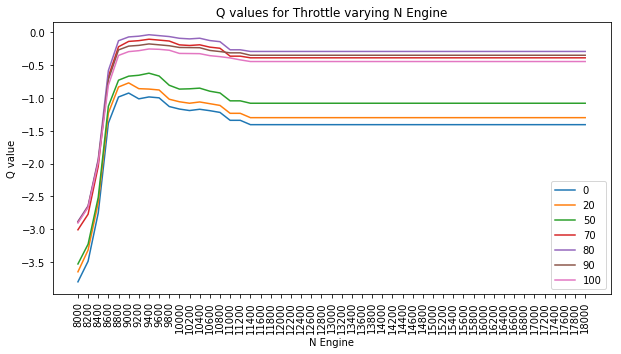

In [31]:
plt.figure(figsize=[10,5])
plt.plot(q_value[:, [thrt_0[0], thrt_20[0], thrt_50[0], thrt_70[0], thrt_80[0], thrt_90[0], thrt_100[0]]])
plt.xticks(range(n_slices), engine_variations, rotation=90)
plt.legend(['0', '20', '50', '70', '80', '90', '100'])
plt.xlabel('N Engine')
plt.ylabel('Q value')
plt.title('Q values for Throttle varying N Engine')

# Yaw Body slice
For the yaw speed slice we focus on the middle of a curve when the yaw acceleration is high.

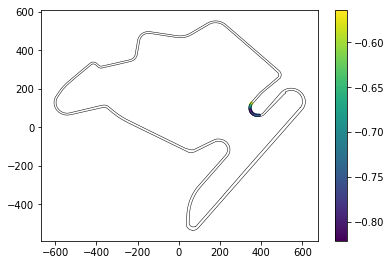

In [32]:
f, ax = plot_track(track_in, track_out)
interval = range(630,660)
lap_mask = simulation.NLap == 1
v = simulation.nYawBody[lap_mask].values[interval]
s = ax.scatter(simulation.xCarWorld[lap_mask].values[interval],
               simulation.yCarWorld[lap_mask].values[interval],
           c=v, s=5)
f.colorbar(s, ax=ax)

See the point to examine (red line)

In [33]:
position = 641

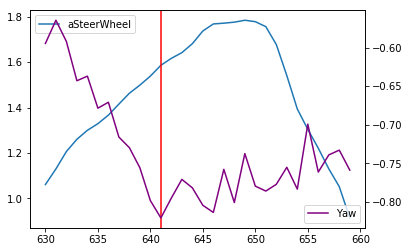

In [34]:
f, ax = plt.subplots()
ax.plot(interval, simulation['aSteerWheel'][lap_mask].values[interval])

ax.axvline(x=position, color='r')
ax.legend(['aSteerWheel'], loc='upper left')
ax2 = ax.twinx()
ax2.plot(interval, simulation['nYawBody'][lap_mask].values[interval], 'purple')
ax2.legend(['Yaw'], loc='lower right')

All the states features of this point

In [35]:
simulation[state_cols+action_cols][lap_mask].iloc[position]

xCarWorld                              348.779100
yCarWorld                               86.516330
positionReferenceX                     349.206421
positionReferenceY                      87.446701
nYawBody                                -0.821038
nEngine                               8033.000000
NGear                                    3.000000
positionRho                              1.023829
positionTheta                           -0.789529
positionLeft                             0.000000
positionRight                            1.000000
positionRelativeX                        0.720947
positionRelativeY                       -0.726929
actualCurvature                         -0.079367
referenceCurvature                      -0.080257
actualSpeedModule                       30.057369
referenceSpeedAngle                     -0.000000
speedDifferenceVectorModule              0.509583
speedDifferenceOfModules                 0.509583
actualAccelerationModule                25.900511


In [36]:
simulation[reduced_state_cols+action_cols][lap_mask].iloc[position]

xCarWorld                    348.779100
yCarWorld                     86.516330
positionRho                    1.023829
positionTheta                 -0.789529
actualCurvature               -0.079367
referenceCurvature            -0.080257
actualSpeedModule             30.057369
speedDifferenceOfModules       0.509583
actualAccelerationX           -7.231205
actualAccelerationY           24.870590
accelerationDiffX             -0.188402
accelerationDiffY              0.312681
nYawBody                      -0.821038
nEngine                     8033.000000
NGear                          3.000000
prevpBrakeF                    3.376559
prevaSteerWheel                1.538324
prevrThrottlePedal             0.000000
pBrakeF                        1.521429
aSteerWheel                    1.586026
rThrottlePedal                 0.000000
Name: 641, dtype: float64

## All state features
We compute the action set for the state and the set of state variation - actions

In [ ]:
s = simulation[state_cols].values[position, :]

ids = (action_dispatcher_as.kdtree.query_radius(s.reshape(1,-1)[:, action_dispatcher_as.state_mask],
                                                r=action_dispatcher_as.radius))

a = [action_dispatcher_as.actions[i] for i in ids[0]]

print('N actions {}'.format(len(a)))

Plot the action distribution

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
brake = [x[0] for x in a]
steer = [x[1] for x in a]
throt = [x[2] for x in a]
ax.scatter(brake, steer, throt)
ax.set_xlabel('brake')
ax.set_ylabel('steer')
ax.set_zlabel('throt')

f = plt.figure()
plt.scatter(brake, steer)
plt.xlabel('brake')
plt.ylabel('steer')
f = plt.figure()
plt.scatter(brake, throt)
plt.xlabel('brake')
plt.ylabel('throt')
f = plt.figure()
plt.scatter(throt, steer)
plt.xlabel('throt')
plt.ylabel('steer')

In [ ]:
yaw_pos = [i for i,st in enumerate(state_cols) if st == 'nYawBody']

print('Yaw angular speed {}'.format(s[yaw_pos]))

In [ ]:
yaw_variations = np.array(np.arange(-2, 1, 0.1))

print('Number of yaw variations {}'.format(len(yaw_variations)))

Create state slices matrix

In [ ]:
state_slices = np.matlib.repmat(s, len(yaw_variations), 1)

state_slices[:, yaw_pos] = yaw_variations.reshape(-1, 1)

n_actions = len(a)
n_slices = len(state_slices)
state_dim = len(state_cols)
action_dim = len(action_cols)

sa = np.empty((n_slices*n_actions, state_dim+action_dim))
end = 0
for i in range(n_slices):
    # set state interval variables
    start = end
    end = end + n_actions

    # populate the matrix with the ith state prime
    sa[start:end, 0:state_dim] = np.matlib.repmat(state_slices[i, :], n_actions, 1)

    # populate the matrix with the actions of the action set of ith state prime
    sa[start:end, state_dim:] = np.array(a).reshape((n_actions, action_dim))

In [ ]:
sa.shape

Compute the Q values of the slice matrix

In [ ]:
q_value = alg_as._policy.Q.values(sa)

q_value.shape

In [ ]:
q_value = q_value.reshape(n_slices, -1)

q_value.shape

In [ ]:
steer_0 = [i for i,x in enumerate(a) if x[1] <= 0.8]
steer_1 = [i for i,x in enumerate(a) if (x[1]>=0.9) & (x[1]<= 1)]
steer_12 = [i for i,x in enumerate(a) if (x[1]>=1.2) & (x[1]<= 1.22)]
steer_14 = [i for i,x in enumerate(a) if (x[1]>=1.4) & (x[1]<= 1.42)]
steer_16 = [i for i,x in enumerate(a) if (x[1]>=1.6) & (x[1]<= 1.65)]
steer_18 = [i for i,x in enumerate(a) if (x[1]>=1.8) & (x[1]<= 1.85)]
steer_2 = [i for i,x in enumerate(a) if x[1] >= 2]

We compare only steer values that have the other action dimensions more or less constant. If the throttle is too high then we cannot compare the them.

In [ ]:
np.array(a)[steer_0,:]

In [ ]:
np.array(a)[steer_1,:]

In [ ]:
np.array(a)[steer_14,:]

In [ ]:
np.array(a)[steer_16,:]

In [ ]:
np.array(a)[steer_18,:]

In [ ]:
np.array(a)[steer_2,:]

In [ ]:
np.array(a)[[steer_12[0], steer_14[2], steer_16[11], steer_18[9], steer_2[3]], :]

See the standard deviations of the other action dimensions

In [ ]:
np.std(np.array(a)[[steer_12[0], steer_14[2], steer_16[11], steer_18[9], steer_2[3]], :], axis=0)

Plot the Q value slices

In [ ]:
plt.figure(figsize=[10,7])
plt.plot(q_value[:, [steer_12[0], steer_14[2], steer_16[11], steer_18[9], steer_2[3]]])
plt.xticks(range(n_slices), ['{:.2f}'.format(x) for x in yaw_variations], rotation=90)
plt.legend(['0', '1', '1.2', '1.4', '1.6', '1.8', '2'])
plt.xlabel('n Yaw body')
plt.ylabel('Q value')
plt.title('Q values for Steer varying n Yaw body')

## Reduced state features
We compute the action set for the state and the set of state variation - actions

In [37]:
s = simulation[reduced_state_cols].values[position, :]

ids = (action_dispatcher_rs.kdtree.query_radius(s.reshape(1,-1)[:, action_dispatcher_rs.state_mask],
                                                r=action_dispatcher_rs.radius))

a = [action_dispatcher_rs.actions[i] for i in ids[0]]

print('N actions {}'.format(len(a)))

N actions 308


Plot the action distribution

Text(0,0.5,'steer')

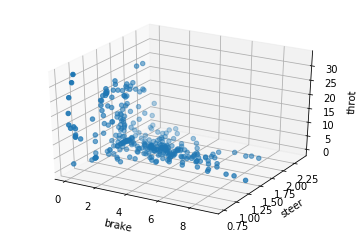

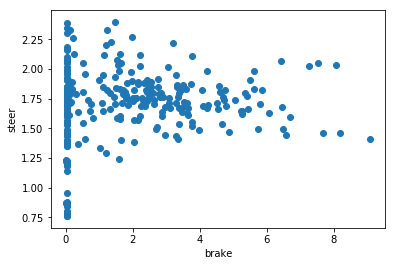

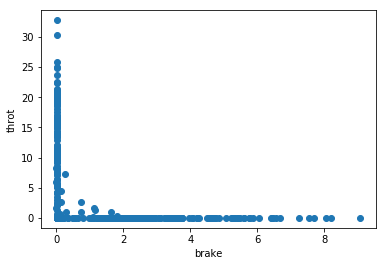

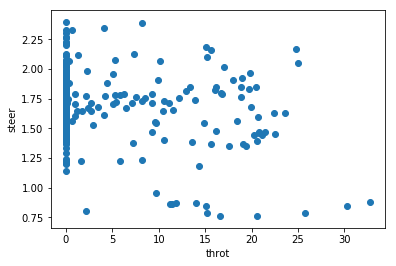

In [38]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
brake = [x[0] for x in a]
steer = [x[1] for x in a]
throt = [x[2] for x in a]
ax.scatter(brake, steer, throt)
ax.set_xlabel('brake')
ax.set_ylabel('steer')
ax.set_zlabel('throt')

f = plt.figure()
plt.scatter(brake, steer)
plt.xlabel('brake')
plt.ylabel('steer')
f = plt.figure()
plt.scatter(brake, throt)
plt.xlabel('brake')
plt.ylabel('throt')
f = plt.figure()
plt.scatter(throt, steer)
plt.xlabel('throt')
plt.ylabel('steer')

In [39]:
yaw_pos = [i for i,st in enumerate(reduced_state_cols) if st == 'nYawBody']

print('Yaw angular speed {}'.format(s[yaw_pos]))

Yaw angular speed [-0.8210381]


In [40]:
yaw_variations = np.array(np.arange(-2, 1, 0.1))

print('Number of yaw variations {}'.format(len(yaw_variations)))

Number of yaw variations 30


Create state slices matrix

In [41]:
state_slices = np.matlib.repmat(s, len(yaw_variations), 1)

state_slices[:, yaw_pos] = yaw_variations.reshape(-1, 1)

n_actions = len(a)
n_slices = len(state_slices)
state_dim = len(reduced_state_cols)
action_dim = len(action_cols)

sa = np.empty((n_slices*n_actions, state_dim+action_dim))
end = 0
for i in range(n_slices):
    # set state interval variables
    start = end
    end = end + n_actions

    # populate the matrix with the ith state prime
    sa[start:end, 0:state_dim] = np.matlib.repmat(state_slices[i, :], n_actions, 1)

    # populate the matrix with the actions of the action set of ith state prime
    sa[start:end, state_dim:] = np.array(a).reshape((n_actions, action_dim))

print('Shape of sa {}'.format(sa.shape))

Shape of sa (9240, 21)


Compute the Q values of the slice matrix

In [42]:
q_value = alg_rs._policy.Q.values(sa)

print('Shape of q_value {}'.format(q_value.shape))

Shape of q_value (9240,)


In [43]:
q_value = q_value.reshape(n_slices, -1)

print('Shape of q_value {}'.format(q_value.shape))

Shape of q_value (30, 308)


Take key actions for which analyse the Q value

In [44]:
steer_0 = [i for i,x in enumerate(a) if x[1] <= 0.8]
steer_1 = [i for i,x in enumerate(a) if (x[1]>=0.9) & (x[1]<= 1)]
steer_12 = [i for i,x in enumerate(a) if (x[1]>=1.2) & (x[1]<= 1.22)]
steer_14 = [i for i,x in enumerate(a) if (x[1]>=1.4) & (x[1]<= 1.42)]
steer_16 = [i for i,x in enumerate(a) if (x[1]>=1.6) & (x[1]<= 1.65)]
steer_18 = [i for i,x in enumerate(a) if (x[1]>=1.8) & (x[1]<= 1.85)]
steer_2 = [i for i,x in enumerate(a) if x[1] >= 2]

In [45]:
np.array(a)[[steer_12[0], steer_14[2], steer_16[11], steer_18[9], steer_2[3]], :]

array([[0.02333008, 1.20862317, 0.        ],
       [1.63305545, 1.40555406, 0.        ],
       [1.11130571, 1.64796317, 1.70961797],
       [1.69788074, 1.82397294, 0.        ],
       [1.65624714, 2.04825783, 0.        ]])

See the standard deviations of the other actions dimensions

In [46]:
np.std(np.array(a)[[steer_12[0], steer_14[2], steer_16[11], steer_18[9], steer_2[3]], :], axis=0)

array([0.63765736, 0.29690852, 0.68384719])

Plot the Q value slices

Text(0.5,1,'Q values for Steer varying n Yaw body')

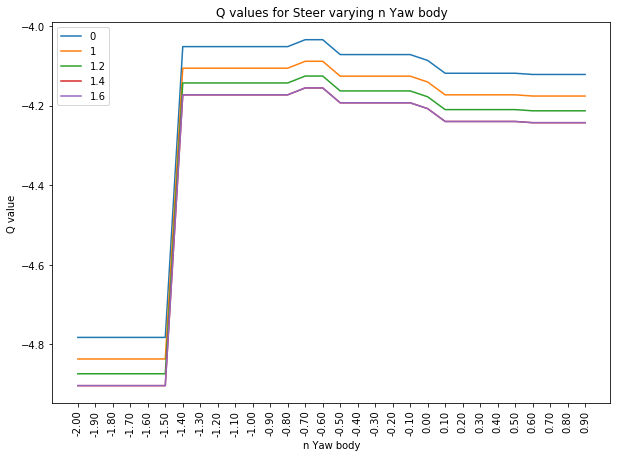

In [47]:
plt.figure(figsize=[10,7])
plt.plot(q_value[:, [steer_12[0], steer_14[2], steer_16[11], steer_18[9], steer_2[3]]])
plt.xticks(range(n_slices), ['{:.2f}'.format(x) for x in yaw_variations], rotation=90)
plt.legend(['0', '1', '1.2', '1.4', '1.6', '1.8', '2'])
plt.xlabel('n Yaw body')
plt.ylabel('Q value')
plt.title('Q values for Steer varying n Yaw body')